In [11]:
import torch
import torch.nn as nn
import numpy as np
import torchvision

# Set the data type and properties
DATA_TYPE = 'int8'  # Using 1 byte per element
assert DATA_TYPE in ['int8']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Extract the first tensor (ignore batch dimension)
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch size)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch size)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Function to estimate memory for generic layers, separating input and output
def estimate_generic(m):
    input_memory = m.input_size
    output_memory = m.output_size
    return input_memory, output_memory

# Function to convert number of elements to kilobytes (KB)
def nelem2kb(n):
    return n / 1024  # Assuming int8 data type (1 byte per element)

# Main function to estimate per-layer memory for AlexNet
def estimate_model_memory(model, x):
    model.eval()
    model.apply(add_io_hooks)  # Apply the hooks to all layers

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []
    layer_names = []

    # Iterate through each layer in the model and calculate memory components
    for name, layer in model.named_modules():
        if len(list(layer.children())) == 0:  # Only profile leaf layers (no child layers)
            in_mem, out_mem = estimate_generic(layer)
            print(f"Layer: {name} | Input Shape: {layer.input_shape} | Output Shape: {layer.output_shape}")
            print(f"Layer: {name} | Input Memory: {in_mem} elements | Output Memory: {out_mem} elements")
            memory_input.append(in_mem)
            memory_output.append(out_mem)
            layer_names.append(name)  # Store layer name for labeling

    # Convert all memory components to kilobytes
    memory_input_kb = [nelem2kb(m) for m in memory_input]
    memory_output_kb = [nelem2kb(m) for m in memory_output]

    # Calculate combined memory (Input + Output)
    combined_memory_kb = [in_kb + out_kb for in_kb, out_kb in zip(memory_input_kb, memory_output_kb)]

    return combined_memory_kb, memory_output_kb, layer_names

# Create the AlexNet model
net = torchvision.models.alexnet()

# Create a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
sample_input = torch.randn(1, 3, 224, 224)

# Estimate the memory usage for AlexNet
combined_memory, output_memory, layer_names = estimate_model_memory(net, sample_input)

# Print the results for debugging
print("\n=== Layer Names ===")
print(layer_names)
print("\n=== Input + Output Memory (KB) ===")
for i, mem in enumerate(combined_memory):
    print(f"{layer_names[i]}: {mem} KB")

print("\n=== Output Memory Only (KB) ===")
for i, mem in enumerate(output_memory):
    print(f"{layer_names[i]}: {mem} KB")


Layer: features.0 | Input Shape: [1, 3, 224, 224] | Output Shape: [1, 64, 55, 55]
Layer: features.0 | Input Memory: 150528 elements | Output Memory: 193600 elements
Layer: features.1 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 55, 55]
Layer: features.1 | Input Memory: 193600 elements | Output Memory: 193600 elements
Layer: features.2 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 27, 27]
Layer: features.2 | Input Memory: 193600 elements | Output Memory: 46656 elements
Layer: features.3 | Input Shape: [1, 64, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.3 | Input Memory: 46656 elements | Output Memory: 139968 elements
Layer: features.4 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.4 | Input Memory: 139968 elements | Output Memory: 139968 elements
Layer: features.5 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 13, 13]
Layer: features.5 | Input Memory: 139968 elements | Output Memory: 32448 elements
Layer: featur

Layer: features.0 | Input Shape: [1, 3, 224, 224] | Output Shape: [1, 64, 55, 55]
Layer: features.0 | Input Memory: 150528 elements | Output Memory: 193600 elements
Layer: features.1 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 55, 55]
Layer: features.1 | Input Memory: 193600 elements | Output Memory: 193600 elements
Layer: features.2 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 27, 27]
Layer: features.2 | Input Memory: 193600 elements | Output Memory: 46656 elements
Layer: features.3 | Input Shape: [1, 64, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.3 | Input Memory: 46656 elements | Output Memory: 139968 elements
Layer: features.4 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.4 | Input Memory: 139968 elements | Output Memory: 139968 elements
Layer: features.5 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 13, 13]
Layer: features.5 | Input Memory: 139968 elements | Output Memory: 32448 elements
Layer: featur

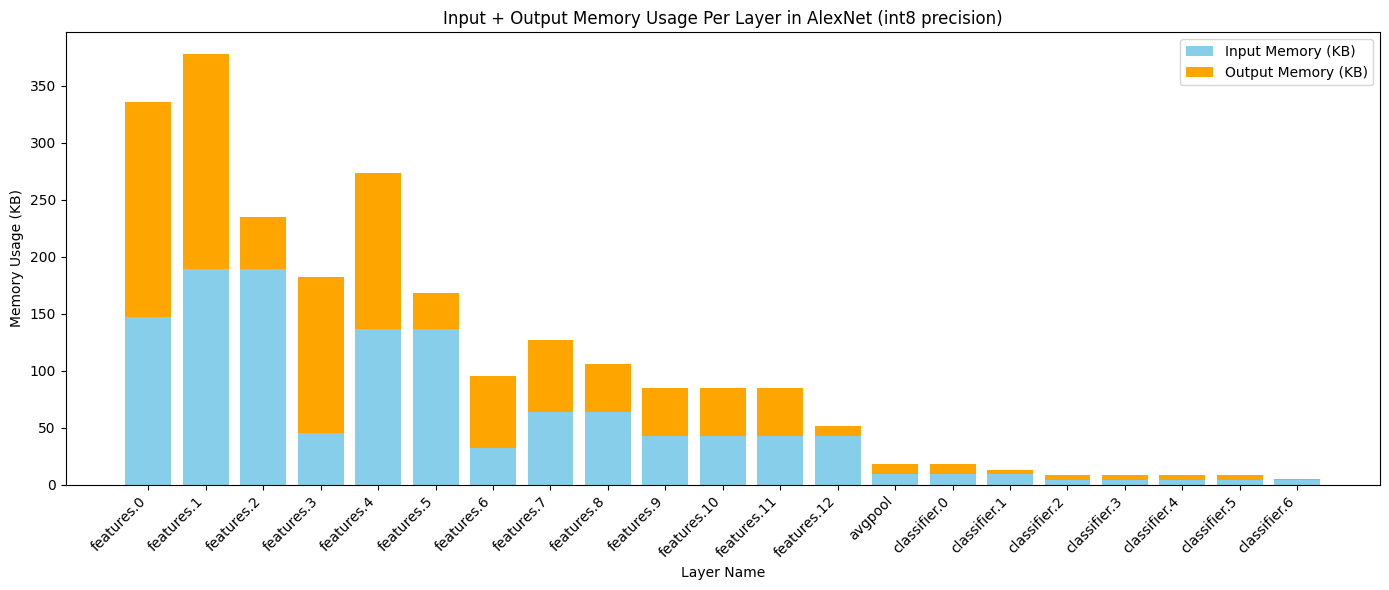

In [15]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# Set the data type and properties
DATA_TYPE = 'int8'  # Change to 'fp' for float32 if needed
assert DATA_TYPE in ['int8', 'fp']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Extract the first tensor (ignore batch dimension)
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch size)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch size)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Function to estimate memory for generic layers, separating input and output
def estimate_generic(m):
    input_memory = m.input_size
    output_memory = m.output_size
    return input_memory, output_memory

# Function to convert number of elements to kilobytes (KB)
def nelem2kb(n, data_type):
    # Convert elements to memory size based on precision type
    element_size = 1 if data_type == 'int8' else 4  # 1 byte for int8, 4 bytes for float32
    return n * element_size / 1024  # Convert to KB

# Main function to estimate per-layer memory for AlexNet
def estimate_model_memory(model, x, data_type):
    model.eval()
    model.apply(add_io_hooks)  # Apply the hooks to all layers

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []
    layer_names = []

    # Iterate through each layer in the model and calculate memory components
    for name, layer in model.named_modules():
        if len(list(layer.children())) == 0:  # Only profile leaf layers (no child layers)
            in_mem, out_mem = estimate_generic(layer)
            print(f"Layer: {name} | Input Shape: {layer.input_shape} | Output Shape: {layer.output_shape}")
            print(f"Layer: {name} | Input Memory: {in_mem} elements | Output Memory: {out_mem} elements")
            memory_input.append(in_mem)
            memory_output.append(out_mem)
            layer_names.append(name)  # Store layer name for labeling

    # Convert all memory components to kilobytes based on data type
    memory_input_kb = [nelem2kb(m, data_type) for m in memory_input]
    memory_output_kb = [nelem2kb(m, data_type) for m in memory_output]

    return memory_input_kb, memory_output_kb, layer_names

# Create the AlexNet model
net = torchvision.models.alexnet()

# Create a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
sample_input = torch.randn(1, 3, 224, 224)

# Estimate the memory usage for AlexNet
memory_input, memory_output, layer_names = estimate_model_memory(net, sample_input, DATA_TYPE)

# Calculate combined memory (Input + Output) for stacked bars
combined_memory_kb = [in_kb + out_kb for in_kb, out_kb in zip(memory_input, memory_output)]

# Plotting a single figure with both Input and Output memory represented in a stacked bar
plt.figure(figsize=(14, 6))
bar1 = plt.bar(layer_names, memory_input, color='skyblue', label='Input Memory (KB)')
bar2 = plt.bar(layer_names, memory_output, bottom=memory_input, color='orange', label='Output Memory (KB)')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Layer Name")
plt.ylabel("Memory Usage (KB)")
plt.title(f"Input + Output Memory Usage Per Layer in AlexNet ({DATA_TYPE} precision)")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
import json
import numpy as np

# Load the model architecture from JSON
def load_model_architecture(json_path):
    with open(json_path, 'r') as file:
        return json.load(file)

# Calculate memory usage based on data type precision
def calculate_memory(layer, precision='int8'):
    element_size = 1 if precision == 'int8' else 4  # int8 = 1 byte, float32 = 4 bytes

    # Calculate memory for different layer types
    if layer["type"] == "Input":
        return np.prod(layer["input_shape"]) * element_size

    if layer["type"] == "Conv":
        input_size = np.prod(layer["input_shape"])
        output_shape = [
            (layer["input_shape"][0] - layer["filter_size"][0] + 2 * layer["padding"]) // layer["stride"] + 1,
            (layer["input_shape"][1] - layer["filter_size"][1] + 2 * layer["padding"]) // layer["stride"] + 1,
            layer["filters"]
        ]
        output_size = np.prod(output_shape)
        return (input_size + output_size) * element_size

    if layer["type"] == "MaxPool":
        input_size = np.prod(layer["input_shape"])
        output_shape = [
            (layer["input_shape"][0] - layer["filter_size"][0]) // layer["stride"] + 1,
            (layer["input_shape"][1] - layer["filter_size"][1]) // layer["stride"] + 1,
            layer["input_shape"][2]
        ]
        output_size = np.prod(output_shape)
        return (input_size + output_size) * element_size

    if layer["type"] == "Flatten":
        input_size = np.prod(layer["input_shape"])
        return input_size * element_size

    if layer["type"] == "FC":
        input_size = np.prod(layer["input_shape"])
        output_size = layer["units"]
        return (input_size + output_size) * element_size

    if layer["type"] == "Dropout":
        # Dropout does not introduce any additional memory overhead
        input_size = np.prod(layer["input_shape"])
        return input_size * element_size

    return 0  # Default to 0 if layer type is not recognized

# Compute the memory for each layer in AlexNet
def compute_memory_usage(layers, precision='int8'):
    total_memory = 0
    print(f"Layer Memory Usage ({precision} precision):")
    for layer in layers:
        mem_usage = calculate_memory(layer, precision)
        total_memory += mem_usage
        print(f"Layer: {layer['name']}, Memory Usage: {mem_usage / 1024:.2f} KB")

    print(f"Total Memory Usage: {total_memory / 1024:.2f} KB\n")

if __name__ == '__main__':
    # Load the AlexNet model architecture
    layers = load_model_architecture('alexnet_architecture.json')

    # Calculate and display memory usage for int8 precision
    compute_memory_usage(layers, precision='int8')

    # Calculate and display memory usage for float32 precision
    compute_memory_usage(layers, precision='float32')


Layer Memory Usage (int8 precision):
Layer: Input, Memory Usage: 147.00 KB
Layer: Conv1, Memory Usage: 420.38 KB
Layer: MaxPool1, Memory Usage: 351.94 KB
Layer: Conv2, Memory Usage: 250.59 KB
Layer: MaxPool2, Memory Usage: 224.50 KB
Layer: Conv3, Memory Usage: 105.62 KB
Layer: Conv4, Memory Usage: 126.75 KB
Layer: Conv5, Memory Usage: 105.62 KB
Layer: MaxPool3, Memory Usage: 51.25 KB
Layer: Flatten, Memory Usage: 9.00 KB
Layer: FC1, Memory Usage: 13.00 KB
Layer: Dropout1, Memory Usage: 4.00 KB
Layer: FC2, Memory Usage: 8.00 KB
Layer: Dropout2, Memory Usage: 4.00 KB
Layer: FC3, Memory Usage: 4.98 KB
Total Memory Usage: 1826.63 KB

Layer Memory Usage (float32 precision):
Layer: Input, Memory Usage: 588.00 KB
Layer: Conv1, Memory Usage: 1681.50 KB
Layer: MaxPool1, Memory Usage: 1407.75 KB
Layer: Conv2, Memory Usage: 1002.38 KB
Layer: MaxPool2, Memory Usage: 898.00 KB
Layer: Conv3, Memory Usage: 422.50 KB
Layer: Conv4, Memory Usage: 507.00 KB
Layer: Conv5, Memory Usage: 422.50 KB
Layer: Ma

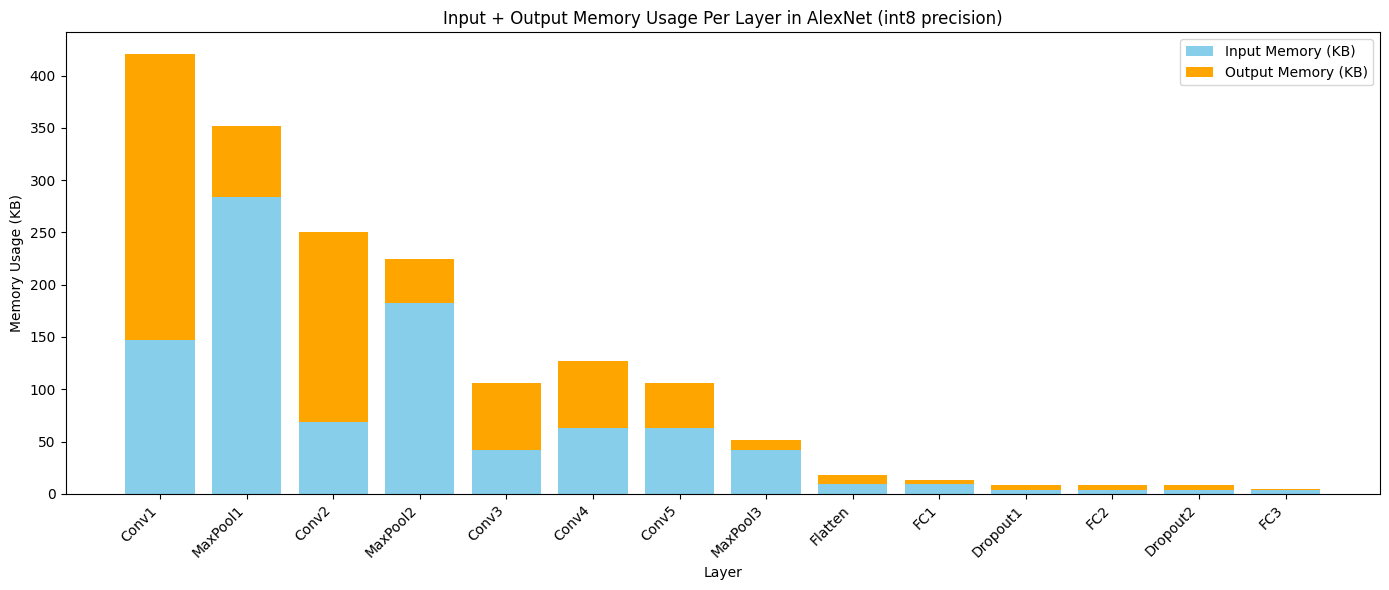

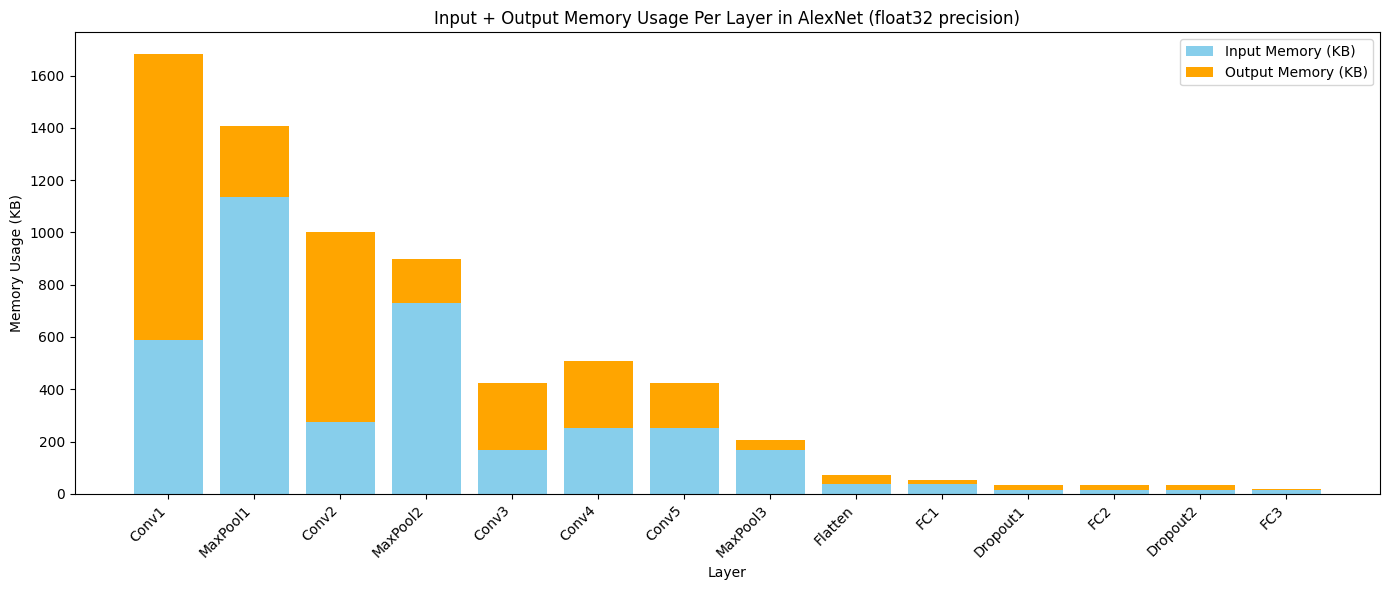

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the AlexNet architecture from the JSON file
def load_model_architecture(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# Function to compute input and output memory size for each layer
def calculate_layer_memory(layer, precision='int8'):
    data_type_size = {'int8': 1, 'float32': 4}
    byte_size = data_type_size[precision]

    # Compute input memory size
    input_shape = layer['input_shape']
    input_memory = np.prod(input_shape) * byte_size / 1024  # Convert to KB

    # Compute output memory size based on layer type
    if layer['type'] == 'Input':
        output_memory = input_memory
    elif layer['type'] in ['Conv', 'MaxPool']:
        output_shape = [
            (input_shape[0] - layer['filter_size'][0] + 2 * layer['padding']) // layer['stride'] + 1,
            (input_shape[1] - layer['filter_size'][1] + 2 * layer['padding']) // layer['stride'] + 1,
            layer['filters'] if layer['type'] == 'Conv' else input_shape[2]
        ]
        output_memory = np.prod(output_shape) * byte_size / 1024  # Convert to KB
    elif layer['type'] == 'Flatten':
        output_memory = np.prod(input_shape) * byte_size / 1024  # Flatten to 1D vector
    elif layer['type'] == 'FC':
        output_memory = layer['units'] * byte_size / 1024  # Convert to KB
    elif layer['type'] == 'Dropout':
        output_memory = np.prod(input_shape) * byte_size / 1024
    else:
        raise ValueError(f"Unsupported layer type: {layer['type']}")

    return input_memory, output_memory

# Compute memory usage for the entire AlexNet model
def calculate_model_memory(layers, precision='int8'):
    memory_usage = {}
    for layer in layers:
        input_mem, output_mem = calculate_layer_memory(layer, precision)
        memory_usage[layer['name']] = {"input_memory": input_mem, "output_memory": output_mem}
    return memory_usage

# Plot the input and output memory usage for the layers
def plot_memory_usage(memory_usage, title):
    layer_names = list(memory_usage.keys())
    input_memory = [memory_usage[layer]['input_memory'] for layer in layer_names]
    output_memory = [memory_usage[layer]['output_memory'] for layer in layer_names]

    # Create stacked bar plot
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(layer_names)), input_memory, label='Input Memory (KB)', color='skyblue')
    plt.bar(range(len(layer_names)), output_memory, bottom=input_memory, label='Output Memory (KB)', color='orange')
    plt.xticks(range(len(layer_names)), layer_names, rotation=45, ha='right')
    plt.xlabel('Layer')
    plt.ylabel('Memory Usage (KB)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # Load the architecture JSON file
    json_path = 'alexnet_architecture.json'
    alexnet_layers = load_model_architecture(json_path)

    # Calculate memory usage for each layer
    int8_memory_usage = calculate_model_memory(alexnet_layers, precision='int8')
    float32_memory_usage = calculate_model_memory(alexnet_layers, precision='float32')

    # Plot memory usage for int8 and float32 precisions
    plot_memory_usage(int8_memory_usage, 'Input + Output Memory Usage Per Layer in AlexNet (int8 precision)')
    plot_memory_usage(float32_memory_usage, 'Input + Output Memory Usage Per Layer in AlexNet (float32 precision)')

if __name__ == '__main__':
    main()
